**Итоговое задание Илларионова Артёма**

по проекту 3 О вкусной и здоровой пище

# Импорт бибилиотек и данных

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import datetime
from datetime import datetime, timedelta
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import os
import re

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
pd.set_option('display.max_columns', 100)

columns_train = [c.lower().replace(' ', '_') for c in df_train.columns]
df_train.columns = columns_train
display(df_train.head(2))
df_train.info()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
restaurant_id        40000 non-null object
city                 40000 non-null object
cuisine_style        30717 non-null object
ranking              40000 non-null float64
rating               40000 non-null float64
price_range          26114 non-null object
number_of_reviews    37457 non-null float64
reviews              40000 non-null object
url_ta               40000 non-null object
id_ta                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
columns_test = [c.lower().replace(' ', '_') for c in df_test.columns]
df_test.columns = columns_test
display(df_test.head(2))
df_test.info()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
restaurant_id        10000 non-null object
city                 10000 non-null object
cuisine_style        7693 non-null object
ranking              10000 non-null float64
price_range          6525 non-null object
number_of_reviews    9343 non-null float64
reviews              9998 non-null object
url_ta               10000 non-null object
id_ta                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [7]:
#display(sample_submission).head(2)
#sample_submission.info()

In [8]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
restaurant_id        50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
ranking              50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
url_ta               50000 non-null object
id_ta                50000 non-null object
sample               50000 non-null int64
rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


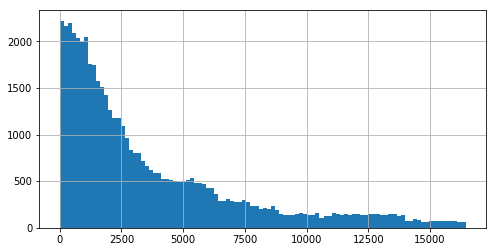

In [9]:
plt.rcParams['figure.figsize'] = (8,4)
df['ranking'].hist(bins=100)

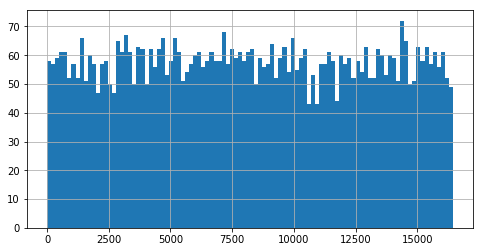

In [10]:
# Распределение в Лондоне
df_train['ranking'][df_train['city'] =='London'].hist(bins=100)

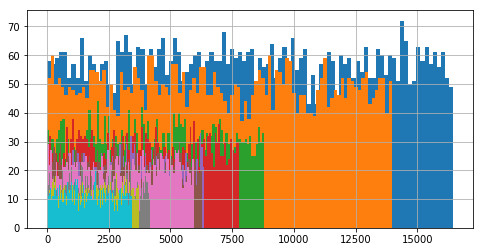

In [11]:
# посмотрим на топ 10 городов
for x in (df_train['city'].value_counts())[0:10].index:
    df_train['ranking'][df_train['city'] == x].hist(bins=100)
plt.show()

#Получается, что Ranking имеет нормальное распределение, 
#просто в больших городах больше ресторанов, из-за мы этого имеем смещение

# Анализ переменных

### 1. restaurant_id

In [12]:
df.restaurant_id.nunique()

13094

In [13]:
# Так как id ресторана не является уникальным, это может стать доп.критерием оценки сетевых заведений
df['rest_group'] = df.restaurant_id.apply(lambda x: float(x[3:]))

In [14]:
# Для сетевых ресторанов добавим количество единиц в сети
df['rest_net_count'] = df['rest_group'].map(df.rest_group.value_counts())

### 2. city

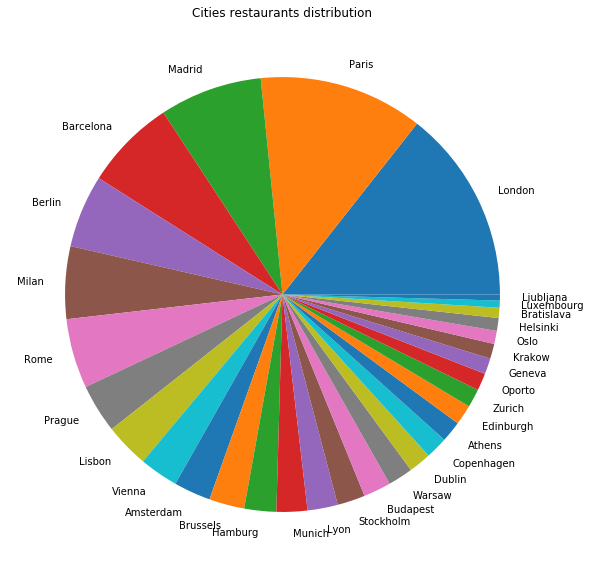

In [15]:
df.groupby('city').size().sort_values(ascending=False).plot(kind='pie', subplots=True, figsize=(10, 10))
plt.title("Cities restaurants distribution")
plt.ylabel("")
plt.show()

# Из графика видно, что косвенно повторяющихся городов (с опечатками) нет, все уникальны
# Наиболее весомым является Лондон, на втором месте Париж

Добавим доп.статистику на основе имеющихся данных о городах

In [16]:
# Признак столицы
list_Of_NotCapitalCity = ['Barcelona', 'Milan', 'Hamburg', 'Munich', 
                          'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']
df['сapital_сity'] = df['city'].apply(lambda x: 0.0 if x in list_Of_NotCapitalCity else 1.0)

In [17]:
# Население городов в тыс.чел.
dict_Сity_population = {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
df['city_population'] = df.apply(lambda row: dict_Сity_population[row['city']], axis = 1)

Добавим признак количества ресторанов на 1 тысячу населения

In [18]:
rest_in_city = df.groupby('city')['id_ta'].count().to_dict()
df['rest_in_city'] = df['city'].map(rest_in_city)
df['rest_density'] = df['rest_in_city'] / (df['city_population'])

Добавим статистику по странам

In [19]:
dict_Сountries = {'London' : 'England', 
                  'Paris' : 'France', 
                  'Madrid' : 'Spain', 
                  'Barcelona' : 'Spain', 
                  'Berlin' : 'Germany', 
                  'Milan' : 'Italy', 
                  'Rome' : 'Italy', 
                  'Prague' : 'Czech_r', 
                  'Lisbon' : 'Portugal', 
                  'Vienna' : 'Austria', 
                  'Amsterdam' : 'Holland', 
                  'Brussels' : 'Belgium', 
                  'Hamburg' : 'Germany', 
                  'Munich' : 'Germany', 
                  'Lyon' : 'France', 
                  'Stockholm' : 'Sweden', 
                  'Budapest' : 'Hungary', 
                  'Warsaw' : 'Poland', 
                  'Dublin' : 'Ireland', 
                  'Copenhagen' : 'Denmark', 
                  'Athens' : 'Greece', 
                  'Edinburgh' : 'Scotland', 
                  'Zurich' : 'Switzerland', 
                  'Oporto' : 'Portugal', 
                  'Geneva' : 'Switzerland', 
                  'Krakow' : 'Poland', 
                  'Oslo' : 'Norway', 
                  'Helsinki' : 'Finland', 
                  'Bratislava' : 'Slovakia', 
                  'Luxembourg' : 'Luxembourg_c', 
                  'Ljubljana' : 'Slovenia'}
df['country'] = df.apply(lambda row: dict_Сountries[row['city']], axis = 1)

In [20]:
# Площадь страны
dict_Country_square = {'England' : 133396, 'France' : 643801, 'Spain' : 505990, 'Germany' : 357385, 
                        'Italy' : 301340, 'Czech_r' : 78866, 'Portugal' : 92226, 'Austria' : 83879, 
                        'Holland' : 41543, 'Belgium' : 30528, 'Sweden' : 447435, 'Hungary' : 93036, 
                        'Poland' : 312679, 'Ireland' : 70273, 'Denmark' : 43094, 'Greece' : 131957, 
                        'Scotland' : 78722, 'Switzerland' : 41284, 'Norway' : 385207, 'Finland' : 338145, 
                        'Slovakia' : 49034, 'Slovenia' : 20273, 'Luxembourg_c' : 2586}
df['Сountry_square'] = df.apply(lambda row: dict_Country_square[row['country']], axis = 1)

# Население страны
dict_Country_population = {'England' : 55977, 'France' : 67848, 'Spain' : 46715, 'Germany' : 83019, 
                        'Italy' : 60588, 'Czech_r' : 10678, 'Portugal' : 10277, 'Austria' : 8924, 
                        'Holland' : 17334, 'Belgium' : 11481, 'Sweden' : 10328, 'Hungary' : 9773, 
                        'Poland' : 38313, 'Ireland' : 4922, 'Denmark' : 5823, 'Greece' : 10741, 
                        'Scotland' : 5438, 'Switzerland' : 8559, 'Norway' : 5368, 'Finland' : 5572, 
                        'Slovakia' : 5455, 'Slovenia' : 2067, 'Luxembourg_c' : 602}
df['Сountry_population'] = df.apply(lambda row: dict_Country_population[row['country']], axis = 1)

# Плотность населения
df['Country_density'] = df.Сountry_population / df.Сountry_square

# Доля населения города к населению страны
df['city_popul_share'] = df.city_population / df.Сountry_population

***
#### Новый признак key_city_rank

Забегая вперёд, нам понадобится дополнительный признак, на основе которого будет вычисляться медианное значение для пропусков. Получен он будет как синтез города и квартиля значения логарифма ranking. 

**#1** key_city_rank 

Визуальный анализ переменной **ranking** и её логарифма

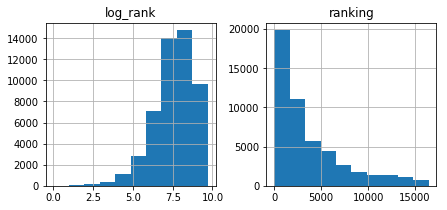

In [21]:
df['log_rank'] = np.log(df.ranking)
df[['log_rank', 'ranking']].hist(figsize=(7, 3), bins=10);

Визуально очевидно, что распределение признака логарифма от ranking ближе к нормальному. Так как все значения **log_rank** непустые, можно воспользоваться им для дальнейшей классификации.

**#2** key_city_rank 

Напишем функцию, которая для каждого города в df выведет список его квартилей по столбцу **log_rank**

In [22]:
def city_rank_quant(dfr):
    city_quantiles = {}     # создаётся словарь типа: {'City': [0.25, 0.5, 0.75]}
    for index, row in dfr.iterrows():
        # получаем список значений квартилей log_rank для каждого текущего города
        q = list(dfr[dfr.city == dfr.city[index]].log_rank.quantile([0.25, 0.5, 0.75]))
        # заполнение словаря, при условии уникальности текущего города 
        if dfr.city[index] in city_quantiles:
            continue
        else:
            city_quantiles[dfr.city[index]] = q
    return city_quantiles

In [23]:
city_rank_quants = city_rank_quant(df)

# Преобразуем полученный маппинг-словарь в df
df_rank = pd.DataFrame(city_rank_quants).T.reset_index()
df_rank.columns = ['city', 'rank_q1', 'rank_q2', 'rank_q3']
df_rank.head(3)

,city,rank_q1,rank_q2,rank_q3
0,Paris,8.146347,8.833536,9.251266
1,Helsinki,5.640118,6.335054,6.723230
2,Edinburgh,6.104793,6.805723,7.193686


In [24]:
# Соединим полученные квартили с исходным df
df = df.merge(df_rank, how='left', on='city')

**#3** key_city_rank 

Определим текущий квартиль в каждом городе df и получим искомый признак **key_city_rank**

In [25]:
rank = []
for index, row in df.iterrows():
    if df.log_rank[index] >= df.rank_q3[index]:
        rank.append(1)
    elif df.log_rank[index] >= df.rank_q2[index]:
        rank.append(2)
    elif df.log_rank[index] >= df.rank_q1[index]:
        rank.append(3)
    else:
        rank.append(4)
df['rank_trh'] = rank

# Финальное действие: получаем ключ-сцепку: city+rank_trh
df['key_city_rank'] = df.city + df.rank_trh.map(str)
df = df.drop(['rank_trh', 'rank_q1', 'rank_q2', 'rank_q3'], axis=1) # убираем вспомогательные столбцы

df.head(2)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,rest_group,rest_net_count,сapital_сity,city_population,rest_in_city,rest_density,country,Сountry_square,Сountry_population,Country_density,city_popul_share,log_rank,key_city_rank
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0.0,16,1.0,2206,6108,2.768812,France,643801,67848,0.105387,0.032514,9.469854,Paris1
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1.0,10,1.0,643,475,0.738725,Finland,338145,5572,0.016478,0.115398,4.663439,Helsinki4


***
#### Новый признак k_ct_rank_nor

Получив классификатор **key_city_rank**, усилим его точность за счёт показателя **Number_of_reviews**. Хоть в нём и содержатся пропуски, они составляют лишь 6.4% выборки. Поэтому, заполнив пропуски в **Number_of_reviews**, добавим квартили количества отзывов в каждом городе в классификатор. 

**#1** k_ct_rank_nor

Визуальный анализ переменной **Number_of_reviews** и её логарифма

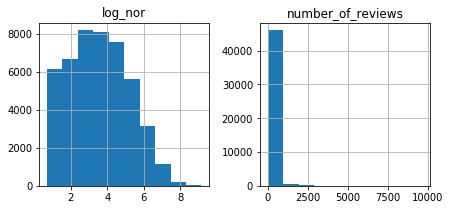

In [26]:
df['log_nor'] = np.log(df.number_of_reviews)
df[['log_nor', 'number_of_reviews']].hist(figsize=(7, 3), bins=10);

# Так же, как с ranking, логарифм показателя Number_of_Reviews ближе к нормальному распределению

**#2** k_ct_rank_nor

Заполним пропуски **log_nor**. 

In [27]:
df['nan_number_of_rev'] = pd.isna(df['number_of_reviews']).astype('float64')
df.log_nor = df.apply(lambda row: df[df.key_city_rank == row.key_city_rank].log_nor.median() \
                                if pd.isna(row.log_nor) else row.log_nor, axis=1)

**#3** k_ct_rank_nor 

Функция, которая для каждого города в df выведет список квартилей значения **log_rank**

In [28]:
def city_nor_quant(dfr):
    city_quantiles = {}
    for index, row in dfr.iterrows():
        q = list(dfr[dfr.city == dfr.city[index]].log_nor.quantile([0.25, 0.5, 0.75]))
        if dfr.city[index] in city_quantiles:
            continue
        else:
            city_quantiles[dfr.city[index]] = q
    return city_quantiles

In [29]:
# Запуск функции
city_nor_quants = city_nor_quant(df)

# Преобразование полученного словаря в df
df_nor = pd.DataFrame(city_nor_quants).T.reset_index()
df_nor.columns = ['city', 'nor_q1', 'nor_q2', 'nor_q3']

# Объединение значений квартилей с исходным df
df = df.merge(df_nor, how='left', on='city')

# Определение текущего квартиля в каждой строке df
numb = []
for index, row in df.iterrows():
    if df.log_nor[index] >= df.nor_q3[index]:
        numb.append(4)
    elif df.log_nor[index] >= df.nor_q2[index]:
        numb.append(3)
    elif df.log_nor[index] >= df.nor_q1[index]:
        numb.append(2)
    else:
        numb.append(1)
df['nor_trh'] = numb

# Финальное действие: новый ключ-сцепка key_city_rank + nor_trh
df['k_ct_rank_nor'] = df.key_city_rank + df.nor_trh.map(str)
df = df.drop(['nor_trh', 'nor_q1', 'nor_q2', 'nor_q3'], axis=1) # убираем вспомогательные столбцы
df.head(2)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,rest_group,rest_net_count,сapital_сity,city_population,rest_in_city,rest_density,country,Сountry_square,Сountry_population,Country_density,city_popul_share,log_rank,key_city_rank,log_nor,nan_number_of_rev,k_ct_rank_nor
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0.0,16,1.0,2206,6108,2.768812,France,643801,67848,0.105387,0.032514,9.469854,Paris1,1.386294,0.0,Paris11
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1.0,10,1.0,643,475,0.738725,Finland,338145,5572,0.016478,0.115398,4.663439,Helsinki4,4.574711,0.0,Helsinki44


### 3. cuisine_style

Посчитаем количество типов кухней для каждого ретсорана. В данных, где были пропуски,  заменим их средней по **k_ct_rank_nor**.

In [30]:
# Создание признака NaN для cuisine_style
df['nan_cuis_style'] = pd.isna(df['cuisine_style']).astype('float64')

# Действие 1 - вычисление количества типов кухней
cuis_count_temp = [] 
for i in df.cuisine_style:
    if pd.isna(i):
        c = 0
    else:
        c = i.count(',') + 1
    cuis_count_temp.append(c)
df['cuis_count'] = cuis_count_temp

# Действие 2 - вычисление среднего по k_ct_rank_nor в пропусках
cuis_count_fin = []
for i, row in df.iterrows():
    if df.cuis_count[i] == 0:
        c = round(df[(df.k_ct_rank_nor == df.k_ct_rank_nor[i]) & (df.nan_cuis_style == False)].cuis_count.mean(), 0)
    else:
        c = df.cuis_count[i]
    cuis_count_fin.append(c)
df['cuis_count'] = cuis_count_fin

df.cuisine_style = df.cuisine_style.fillna('NaN')

In [31]:
# Обработка и нормирование количества типов кухней
def norm(x, fieldname):
    return (x[fieldname] - x[fieldname].min()) / (x[fieldname].max() - x[fieldname].min())

def convert_cuis(c):
    lc = re.compile('\[.*\]')
    if type(c) == str and lc.fullmatch(c):
        lst = eval(c)
        return lst
    else:
        return ['NaN']

df['Cuis1'] = df['cuisine_style'].apply(convert_cuis)
df['Cuisine_count'] = df['Cuis1'].apply(lambda x: len(x))
df['Cuisine_count_n'] = norm(df,'Cuisine_count')
df.drop(['Cuisine_count'], axis=1, inplace=True)

Добавим доп.признаки: местная кухня, вегетарианское меню

In [32]:
def is_local_cuisine(row):
    local_cuisine_by_country = {
        'England': ['British','Scottish','Irish'],
        'Scotland': ['British','Scottish','Irish'],
        'Ireland': ['British','Scottish','Irish'],
        'France': ['French','Central European', 'Mediterranean'],
        'Spain': ['Spanish', 'Mediterranean'],
        'Germany': ['German','Central European'],
        'Italy': ['Italian', 'Mediterranean', 'Pizza'],
        'Czech_r': ['Czech','Eastern European'],
        'Portugal': ['Portuguese','Mediterranean'],
        'Austria': ['Austrian','German','Central European'],
        'Poland': ['Polish','Eastern European'],
        'Holland': ['Scandinavian', 'Dutch', 'Central European'],
        'Belgium': ['Belgian', 'Central European'],
        'Switzerland':['Swiss','Central European'],
        'Sweden': ['Scandinavian'],
        'Hungary':['Hungarian','Eastern European'],
        'Denmark':['Scandinavian'],
        'Greece':['Greece', 'Mediterranean'],
        'Norway':['Scandinavian'],
        'Finland':['Scandinavian'],
        'Slovakia':['Eastern European'],
        'Luxembourg_c':['Central European'],
        'Slovenia':['Slovenian','Eastern European']
    }
    loc_cuis = local_cuisine_by_country[row['country']]
    
    for lc in loc_cuis:
        if lc in row['Cuis1'] and lc != '':
            return 1
    else:
        return 0
    return 0

df['local_cuisine'] = df.apply(is_local_cuisine, axis=1)

In [33]:
def is_veget_cuisine(row):
    veget_cuis = ['Vegetarian Friendly', 'Healthy', 'Vegan Options', 'Gluten Free Options']
    for ct in veget_cuis:
        if ct in row['Cuis1'] and ct != '':
            return 1
    else:
        return 0
    return 0

df['veget_cuisine'] = df.apply(is_veget_cuisine, axis=1)

In [34]:
df.sample(3)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,rest_group,rest_net_count,сapital_сity,city_population,rest_in_city,rest_density,country,Сountry_square,Сountry_population,Country_density,city_popul_share,log_rank,key_city_rank,log_nor,nan_number_of_rev,k_ct_rank_nor,nan_cuis_style,cuis_count,Cuis1,Cuisine_count_n,local_cuisine,veget_cuisine
33231,id_16362,London,"['Indian', 'Asian', 'Bangladeshi', 'Halal']",16380.0,NaN,2.0,"[['Very Small Portions', 'Stay very away'], ['...",/Restaurant_Review-g186338-d10765583-Reviews-M...,d10765583,1,1.0,16362.0,1,1.0,8908,7193,0.807476,England,133396,55977,0.419630,0.159137,9.703816,London1,0.693147,0.0,London11,0.0,4.0,"[Indian, Asian, Bangladeshi, Halal]",0.15,0,0
17862,id_8562,Madrid,['Spanish'],8569.0,NaN,4.0,"[['cheap, and ok if you are 20 yrs old'], ['01...",/Restaurant_Review-g187514-d10713497-Reviews-C...,d10713497,1,2.0,8562.0,3,1.0,3223,3813,1.183059,Spain,505990,46715,0.092324,0.068993,9.055906,Madrid1,1.386294,0.0,Madrid11,0.0,1.0,[Spanish],0.00,1,0
42683,id_10327,London,NaN,10336.0,NaN,11.0,"[['Tour of Spitalfields Market', 'Still some s...",/Restaurant_Review-g186338-d12640973-Reviews-O...,d12640973,1,3.5,10327.0,1,1.0,8908,7193,0.807476,England,133396,55977,0.419630,0.159137,9.243388,London2,2.397895,0.0,London22,1.0,2.0,[NaN],0.00,0,0


### 4. price_range

Перекодируем в числовой формат и так же заменим пропуски средней по **k_ct_rank_nor**.

In [35]:
# Создание признака NaN для price_range
df['nan_price_range'] = pd.isna(df['price_range']).astype('float64')

# Замена пропусков и нечисловых значений
range_dict = {"$": 1, "$$ - $$$": 2, "$$$$": 3, "0": 0}
df['price_range'] = df['price_range'].fillna('0')
df['price_range'] = df['price_range'].map(range_dict)

# Заполнение пропусков
keys = df.k_ct_rank_nor.unique()
keys_price_range = {}
for key in keys:
    keys_price_range[key] = round(df[(df.k_ct_rank_nor == key) & (df.price_range > 0)].price_range.mean(), 2)
for key in keys:
    mask = (df.k_ct_rank_nor == key) & (df.price_range == 0)
    df.loc[mask, 'price_range'] = keys_price_range[key]
df.head(2)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,rest_group,rest_net_count,сapital_сity,city_population,rest_in_city,rest_density,country,Сountry_square,Сountry_population,Country_density,city_popul_share,log_rank,key_city_rank,log_nor,nan_number_of_rev,k_ct_rank_nor,nan_cuis_style,cuis_count,Cuis1,Cuisine_count_n,local_cuisine,veget_cuisine,nan_price_range
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0.0,16,1.0,2206,6108,2.768812,France,643801,67848,0.105387,0.032514,9.469854,Paris1,1.386294,0.0,Paris11,0.0,2.0,"[Bar, Pub]",0.05,0,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1.0,10,1.0,643,475,0.738725,Finland,338145,5572,0.016478,0.115398,4.663439,Helsinki4,4.574711,0.0,Helsinki44,0.0,5.0,"[European, Scandinavian, Gluten Free Options, ...",0.20,1,1,0.0


Есть один проблемный ресторан, который содержит пропуски и не имеет "собратьев" по коду. Это брюссельский сетевой ресторан с id_771.

In [36]:
df[df.price_range.isna() == True]

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,rest_group,rest_net_count,сapital_сity,city_population,rest_in_city,rest_density,country,Сountry_square,Сountry_population,Country_density,city_popul_share,log_rank,key_city_rank,log_nor,nan_number_of_rev,k_ct_rank_nor,nan_cuis_style,cuis_count,Cuis1,Cuisine_count_n,local_cuisine,veget_cuisine,nan_price_range
12541,id_774,Brussels,NaN,775.0,NaN,8.0,"[['Great place for good cheese'], ['12/09/2017']]",/Restaurant_Review-g188644-d12878264-Reviews-L...,d12878264,1,5.0,774.0,13,1.0,179,1314,7.340782,Belgium,30528,11481,0.376081,0.015591,6.652863,Brussels4,2.079442,0.0,Brussels41,1.0,NaN,[NaN],0.0,0,0,1.0


In [37]:
# Для него напишем личный код замены пропусков
df.loc[df.k_ct_rank_nor == 'Brussels41', 'cuis_count'] = df[df.restaurant_id == 'id_774'].cuis_count.mean()
df.loc[df.k_ct_rank_nor == 'Brussels41', 'price_range'] = df[df.restaurant_id == 'id_774'].price_range.mean()
df[df.k_ct_rank_nor == 'Brussels41']

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,rest_group,rest_net_count,сapital_сity,city_population,rest_in_city,rest_density,country,Сountry_square,Сountry_population,Country_density,city_popul_share,log_rank,key_city_rank,log_nor,nan_number_of_rev,k_ct_rank_nor,nan_cuis_style,cuis_count,Cuis1,Cuisine_count_n,local_cuisine,veget_cuisine,nan_price_range
12541,id_774,Brussels,NaN,775.0,1.930833,8.0,"[['Great place for good cheese'], ['12/09/2017']]",/Restaurant_Review-g188644-d12878264-Reviews-L...,d12878264,1,5.0,774.0,13,1.0,179,1314,7.340782,Belgium,30528,11481,0.376081,0.015591,6.652863,Brussels4,2.079442,0.0,Brussels41,1.0,4.0,[NaN],0.0,0,0,1.0


### 4. reviews

Выделим текст отзывов и даты их написания в отдельные столбцы

In [38]:
# Отдельно отметим пустые отзывы
df['reviews'].fillna('[[], []]', inplace=True)
df['nan_review'] = (df['reviews'] == '[[], []]').astype('float64')

In [40]:
# Выделим отдельно текст и даты из отзывов на 1й и 2й
rev_templ = re.compile('\[\[.*\]\]')
def extr_rev(row):
    rev = row['reviews']
    lst = [[],[]]
    if type(rev) == str and rev_templ.fullmatch(rev):
        nan = ''
        lst = eval(rev)

    row['rev1'] = lst[0][0] if len(lst[0]) > 0 else ''
    row['rev2'] = lst[0][1] if len(lst[0]) > 1 else ''
    row['date1'] = pd.to_datetime(lst[1][0] if len(lst[1]) > 0 else '', format='%m/%d/%Y', errors='coerce')
    row['date2'] = pd.to_datetime(lst[1][1] if len(lst[1]) > 1 else '', format='%m/%d/%Y', errors='coerce')
    row['date1'] = pd.to_datetime(row['date1'])
    row['date2'] = pd.to_datetime(row['date2'])
    
    return row

df = df.apply(extr_rev, axis=1)

Далее возьмем разницу во времени м\д отзывами, определив 1й и последний

In [41]:
def get_date_delta(row, date_min, date_max):
    date1 = row['date1']
    date2 = row['date2']
    delta = date_max-date_min
    if not pd.isnull(date1) and not pd.isnull(date2):
        delta = date1 - date2 if date2 < date1 else date2-date1
    elif not pd.isnull(date1):
        delta = date1 - date_min
    return delta.total_seconds()

def get_last_date_delta(row, date_min, date_max):
    date1 = row['date1']
    date2 = row['date2']
    last_date = date_min
    if not pd.isnull(date1):
        last_date = date1
    if (not pd.isnull(date2)) and date2 > date1:
        last_date = date2
    return (date_max-last_date).total_seconds()

def get_first_date_delta(row, date_min, date_max):
    date1 = row['date1']
    date2 = row['date2']
    first_date = date_min
    if not pd.isnull(date1):
        first_date = date1
    if (not pd.isnull(date2)) and date2 < date1:
        first_date = date2
    return (first_date-date_min).total_seconds()

In [42]:
# Запуск функции
date_min = min([df.date1.min(),df.date2.min()])
date_max = max([df.date1.max(),df.date2.max()])
df['date_delta_sec'] = df[['date1','date2']].apply(get_date_delta, axis=1, date_min=date_min, date_max=date_max)
df['last_date_delta'] = df[['date1','date2']].apply(get_last_date_delta, axis=1, date_min=date_min, date_max=date_max)
df['first_date_delta'] = df[['date1','date2']].apply(get_first_date_delta, axis=1, date_min=date_min, date_max=date_max)

df['date_delta_n'] = norm(df,'date_delta_sec')
df['last_date_delta_n'] = norm(df,'last_date_delta')
df['first_date_delta_n'] = norm(df,'first_date_delta')

df['date_n_mult'] = df['date_delta_n'] * df['first_date_delta_n']
df.drop(['date_delta_n','last_date_delta_n','first_date_delta_n'], axis=1, inplace=True)
df.drop(['date_delta_sec','last_date_delta','first_date_delta'], axis=1, inplace=True)

Далее оценим качество отзывов по ключевым словам

In [59]:
positive = ["awesome", "excellent", "great", "good", "not bad", 'nice', 'lovely', 
            'perfect', 'reasonable', 'beautiful', 'super', 'best', 'yummy', 'yum', 'Fine',  
            'tasty', 'delicious', 'wonderful', 'marvelous', 'fabulous', 'Gorgeous',
            'Fantastic', 'cozy', 'cosy', 'pleasant', 'Heaven', 'cute', 'Charm', 'enjoy']

def is_posit(s):
    for word in positive:
        if word.lower() in s.lower():
            return 1
    return 0

df['posit_rev'] = df.reviews.apply(is_posit)

negative = ["awful", "terrible", "bad", "horrible", 'worst', 'tasteless', 'not great', 
            'disgusting', 'rancid', 'rotten', 'smelly', 'stinky', 'Shame', 'Overprice', 
            'dirty', 'messy', 'avoid', 'noisy', 'Worse', 'dissapoint', 'disappoint',
            'Lack of', 'not ok', 'waste', 'wasting', "Don't ", "Don’t ", 'dont ']

def is_negat(s):
    for word in negative:
        if word.lower() in s.lower():
            return 1
    return 0

df['negat_rev'] = df.reviews.apply(is_negat)
print(df.posit_rev.sum(), df.negat_rev.sum())
df.sample(2)

31399 3147


,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,rest_group,rest_net_count,сapital_сity,city_population,rest_in_city,rest_density,country,Сountry_square,Сountry_population,Country_density,city_popul_share,log_rank,key_city_rank,log_nor,nan_number_of_rev,k_ct_rank_nor,nan_cuis_style,cuis_count,Cuis1,Cuisine_count_n,local_cuisine,veget_cuisine,nan_price_range,nan_review,rev1,rev2,date1,date2,date_n_mult,posit_rev,negat_rev,rev_sum,code_id_ta,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,...,Price_Range_1.67,Price_Range_1.68,Price_Range_1.69,Price_Range_1.7,Price_Range_1.71,Price_Range_1.72,Price_Range_1.73,Price_Range_1.74,Price_Range_1.75,Price_Range_1.76,Price_Range_1.77,Price_Range_1.78,Price_Range_1.79,Price_Range_1.8,Price_Range_1.81,Price_Range_1.82,Price_Range_1.83,Price_Range_1.84,Price_Range_1.85,Price_Range_1.86,Price_Range_1.87,Price_Range_1.88,Price_Range_1.89,Price_Range_1.9,Price_Range_1.91,Price_Range_1.92,Price_Range_1.93,Price_Range_1.9308333333333332,Price_Range_1.94,Price_Range_1.95,Price_Range_1.96,Price_Range_1.97,Price_Range_1.98,Price_Range_1.99,Price_Range_2.0,Price_Range_2.01,Price_Range_2.02,Price_Range_2.03,Price_Range_2.04,Price_Range_2.05,Price_Range_2.06,Price_Range_2.07,Price_Range_2.08,Price_Range_2.09,Price_Range_2.1,Price_Range_2.13,Price_Range_2.25,Price_Range_2.4,Price_Range_2.5,Price_Range_3.0
43157,id_2518,Lisbon,NaN,2521.0,1.59,8.0,"[['good value very local experience', 'Nice pl...",/Restaurant_Review-g189158-d10591712-Reviews-A...,d10591712,1,4.0,2518.0,5,1.0,506,1647,3.254941,Portugal,92226,10277,0.111433,0.049236,7.832411,Lisbon2,2.079442,0.0,Lisbon21,1.0,2.0,[NaN],0.0,0,0,1.0,0.0,good value very local experience,Nice place,2016-09-29,2016-07-26,0.011375,1,0,1,10591712.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402,id_402,Lyon,['Cafe'],1493.0,1.85,4.0,"[[], []]",/Restaurant_Review-g187265-d4887793-Reviews-Co...,d4887793,0,0.0,402.0,12,0.0,506,1126,2.225296,France,643801,67848,0.105387,0.007458,7.308543,Lyon2,1.386294,0.0,Lyon21,0.0,1.0,[Cafe],0.0,0,0,1.0,1.0,,,NaT,NaT,0.000000,0,0,0,4887793.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5. id_ta

Возможно, чем больше id на сайте TripAdvisor, тем младше ресторан

In [44]:
df['code_id_ta'] = df['id_ta'].apply(lambda x: float(x[1:]))

### Далее добавим dummy-переменные

In [47]:
df_City_dummies = pd.get_dummies(df['city'], dummy_na=False).astype('float64')
df_price_range = pd.get_dummies(df['price_range'], dummy_na=False, prefix = 'Price_Range').astype('float64')
#pd.get_dummies(df_output, columns=['country'])

df = pd.concat([df, df_City_dummies], axis=1)
df = pd.concat([df, df_price_range], axis=1)

### Подготовка датафрейма к обучению

In [67]:
col_to_drop = ['restaurant_id', 'city', 'cuisine_style', 'reviews', 'url_ta', 'id_ta', 'country',
               'key_city_rank', 'k_ct_rank_nor', 'Cuis1', 'rev1', 'rev2', 'date1', 'date2', 
               'number_of_reviews']
df_ml = df.drop(col_to_drop, axis=1)

####

train_data = df_ml.query('sample == 1').drop(['sample'], axis=1)
test_data = df_ml.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values   # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [68]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [69]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 146), (40000, 146), (40000, 145), (32000, 145), (8000, 145))

# Model 
Сам ML

In [52]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [70]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [71]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [72]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.208713125


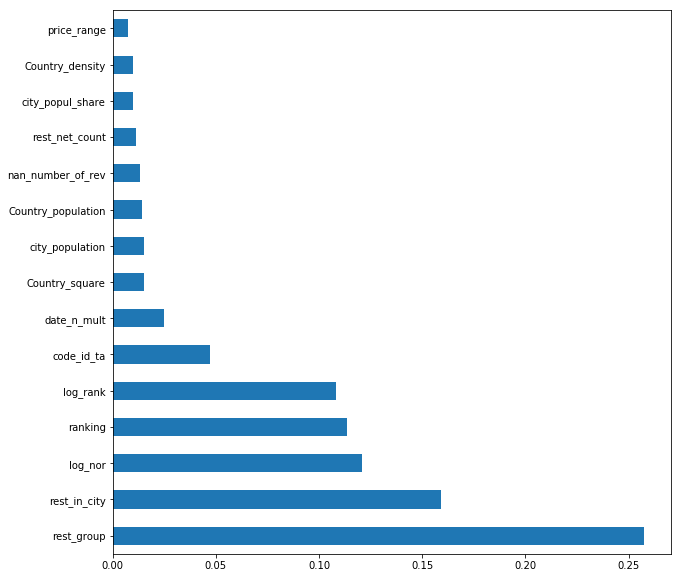

In [73]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [74]:
test_data.sample(10)

,ranking,price_range,rating,rest_group,rest_net_count,сapital_сity,city_population,rest_in_city,rest_density,Сountry_square,Сountry_population,Country_density,city_popul_share,log_rank,log_nor,nan_number_of_rev,nan_cuis_style,cuis_count,Cuisine_count_n,local_cuisine,veget_cuisine,nan_price_range,nan_review,date_n_mult,posit_rev,negat_rev,code_id_ta,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,...,Price_Range_1.67,Price_Range_1.68,Price_Range_1.69,Price_Range_1.7,Price_Range_1.71,Price_Range_1.72,Price_Range_1.73,Price_Range_1.74,Price_Range_1.75,Price_Range_1.76,Price_Range_1.77,Price_Range_1.78,Price_Range_1.79,Price_Range_1.8,Price_Range_1.81,Price_Range_1.82,Price_Range_1.83,Price_Range_1.84,Price_Range_1.85,Price_Range_1.86,Price_Range_1.87,Price_Range_1.88,Price_Range_1.89,Price_Range_1.9,Price_Range_1.91,Price_Range_1.92,Price_Range_1.93,Price_Range_1.9308333333333332,Price_Range_1.94,Price_Range_1.95,Price_Range_1.96,Price_Range_1.97,Price_Range_1.98,Price_Range_1.99,Price_Range_2.0,Price_Range_2.01,Price_Range_2.02,Price_Range_2.03,Price_Range_2.04,Price_Range_2.05,Price_Range_2.06,Price_Range_2.07,Price_Range_2.08,Price_Range_2.09,Price_Range_2.1,Price_Range_2.13,Price_Range_2.25,Price_Range_2.4,Price_Range_2.5,Price_Range_3.0
3727,13901.0,2.00,0.0,3727.0,1,1.0,2206,6108,2.768812,643801,67848,0.105387,0.032514,9.539716,1.386294,0.0,0.0,1.0,0.00,0,0,0.0,1.0,0.000000,0,0,4961425.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3117,8408.0,2.00,0.0,3117.0,6,1.0,2206,6108,2.768812,643801,67848,0.105387,0.032514,9.036939,4.317488,0.0,0.0,5.0,0.20,0,1,0.0,0.0,0.012850,1,0,2719256.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3347,11312.0,2.00,0.0,3347.0,5,1.0,8908,7193,0.807476,133396,55977,0.419630,0.159137,9.333619,2.484907,0.0,0.0,1.0,0.00,0,0,0.0,0.0,0.103516,1,0,1544120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8464,3753.0,2.00,0.0,8464.0,3,1.0,2872,2589,0.901462,301340,60588,0.201062,0.047402,8.230311,5.342334,0.0,0.0,2.0,0.05,1,0,0.0,0.0,0.000576,1,0,2446097.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9398,10950.0,1.68,0.0,9398.0,1,1.0,2206,6108,2.768812,643801,67848,0.105387,0.032514,9.301095,2.564949,1.0,1.0,2.0,0.00,0,0,1.0,0.0,0.846298,1,0,11913770.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9956,2815.0,2.00,0.0,9956.0,1,0.0,1620,3395,2.095679,505990,46715,0.092324,0.034678,7.942718,5.220356,0.0,0.0,4.0,0.15,1,0,0.0,0.0,0.009103,0,0,1070720.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [75]:
test_data = test_data.drop(['rating'], axis=1)

In [76]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [77]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [78]:
predict_submission

array([4.605, 4.26 , 4.495, ..., 2.725, 3.605, 3.975])

In [ ]:
sample_submission['rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
